# out_fiberID
* cv를 추가변수사용해서 진행

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
# path = "/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/data/" #colab
path = "./data/" #local
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_df.shape, test_df.shape

((199991, 22), (10009, 21))

## DATA Setting

In [6]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [7]:
train_df = del_outlier(train_df, min=-60, max=60)

In [8]:
train_df.shape

(199805, 22)

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [11]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [12]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

In [13]:
def PCA_feature(data):
    '''
    각 ugriz밴드 끼리 PCA를 통해 추가변수 생성 시도
    '''
    from sklearn.decomposition import PCA
    pca = PCA(1)
    
    ori_name = ["psfMag","fiberMag","petroMag","modelMag"]
    add_name = ["u","g","r","i","z"]
    
    for add in add_name:
        selected = list(map(lambda x : x+"_"+add,ori_name))
        data['PCA_'+add] = pca.fit_transform(data[selected])
    return data

In [14]:
train_df = PCA_feature(train_df)
test_df = PCA_feature(test_df)

In [15]:
def fiberID_agg(data):
    '''
    fiberID는 1~1000까지 숫자로 구성되어있는 카테고리 변수다.
    numeric한 변수가 아니기때문에 이를 이용한 변수 생성이 필요하다 판단되어
    ugriz밴드를 기반으로 통계적 수치 median, std를 산출한다
    '''
    ori_name = ["psfMag","fiberMag","petroMag","modelMag"]
    add_name = ["u","g","r","i","z"]
    
    for add in add_name:
        selected = list(map(lambda x : x+"_"+add,ori_name))
        columns = data[selected].columns 
        columns = list(columns)
        columns.append("fiberID")

        #dictinary_set
#         mean_dict = dict(data[columns].groupby("fiberID").mean().mean(axis = 1))
#         min_dict = dict(data[columns].groupby("fiberID").min().min(axis = 1))
#         max_dict = dict(data[columns].groupby("fiberID").max().max(axis = 1))
        median_dict = dict(data[columns].groupby("fiberID").median().median(axis = 1))
        std_dict = dict(data[columns].groupby("fiberID").std().std(axis = 1))

        #save
#         data["mean_"+add] = data.fiberID.apply(lambda x : mean_dict.get(x))
#         data["min_"+add] = data.fiberID.apply(lambda x : min_dict.get(x))
#         data["max_"+add] = data.fiberID.apply(lambda x : max_dict.get(x))
        data["median_"+add] = data.fiberID.apply(lambda x : median_dict.get(x))
        data["std_"+add] = data.fiberID.apply(lambda x : std_dict.get(x))
    return data

In [16]:
train_df = fiberID_agg(train_df)
test_df = fiberID_agg(test_df)

In [17]:
train_df.shape,test_df.shape

((199805, 78), (10009, 76))

In [18]:
train_df.columns

Index(['type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'type_num', 'psfMag_u-g', 'psfMag_u-r', 'psfMag_u-i',
       'psfMag_u-z', 'psfMag_g-r', 'psfMag_g-i', 'psfMag_g-z', 'psfMag_r-i',
       'psfMag_r-z', 'psfMag_i-z', 'fiberMag_u-g', 'fiberMag_u-r',
       'fiberMag_u-i', 'fiberMag_u-z', 'fiberMag_g-r', 'fiberMag_g-i',
       'fiberMag_g-z', 'fiberMag_r-i', 'fiberMag_r-z', 'fiberMag_i-z',
       'petroMag_u-g', 'petroMag_u-r', 'petroMag_u-i', 'petroMag_u-z',
       'petroMag_g-r', 'petroMag_g-i', 'petroMag_g-z', 'petroMag_r-i',
       'petroMag_r-z', 'petroMag_i-z', 'modelMag_u-g', 'modelMag_u-r',
       'modelMag_u-i', 'modelMag_u-z', 'modelMag_g-r', 'modelMag_g-i',
       'modelMag_g-z', 'modelMag_r-i', 'modelMag_r-z

### CV

In [19]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns = ['fiberID'])

In [20]:
import sklearn
logloss = sklearn.metrics.make_scorer(log_loss,needs_proba=True, labels=train_y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [22]:
params = {"max_depth" : (7,8,9),
         "learning_rate": (0.01,0.05, 0.1),
         "num_leaves": (127,255,511),
         "min_child_samples": (30,40,50),
         "lambda_l1": (0,3,5,7,9),
         "lambda_l2": (0,3,5,7,9)}

In [26]:
defaut_lgbmc = lgb.LGBMClassifier(n_estimators=2000,random_state=1029,objective ="multiclass",class_weight = 'balanced')

In [27]:
random_search  = RandomizedSearchCV(defaut_lgbmc,param_distributions=params, cv=3, verbose =100 ,n_iter = 30,scoring=logloss,random_state = 1029) #server
# random_search  = RandomizedSearchCV(defaut_lgbmc,param_distributions=params, cv=2, verbose =100 ,n_iter = 2,scoring=logloss) #local

In [28]:
#와 3시간.. fold = 3,cv =5, n_iter =2 
# for fold, (train_ids, val_ids) in enumerate(Fold.split(X,y)):
#     print("★", fold, "start")
#     eval_set = [(X.iloc[train_ids], y.iloc[train_ids]),(X.iloc[val_ids], y.iloc[val_ids])]
eval_set = [(X_train,y_train),(X_test,y_test)]
eval_names = ['train','val']
random_search.fit(X_train, y_train, eval_set = eval_set, eval_names = eval_names, early_stopping_rounds = 100,verbose = 100)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] num_leaves=255, min_child_samples=30, max_depth=8, learning_rate=0.01, lambda_l2=9, lambda_l1=5 
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.45509	val's multi_logloss: 2.45878
[CV]  num_leaves=255, min_child_samples=30, max_depth=8, learning_rate=0.01, lambda_l2=9, lambda_l1=5, score=2.458, total=   6.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[CV] num_leaves=255, min_child_samples=30, max_depth=8, learning_rate=0.01, lambda_l2=9, lambda_l1=5 
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.45427	val's multi_logloss: 2.45819
[CV]  num_leaves=255, min_child_samples=30, max_depth=8, learning_rate=0.01, lambda_l2=9, lambda

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight='balanced',
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0, n_estimators=10,
                                            n_jobs=-1, num_leaves=31,
                                            objective='multiclass',
                                            random_state=1029, reg_alpha=0.0,
                                            reg_la...
6          8
7          5
8          8
9          1
10         8
11         8
12         7
13         5
14         5
15       

In [29]:
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_

with open('best_params.txt', 'w' ) as best:
    best.write("best_params : " + str(best_params) + "\n")
    best.write("best_score : " + str(best_score)+"\n")
    best.write("best_model : " + str(best_model)+"\n")

In [30]:
best_params

{'num_leaves': 255,
 'min_child_samples': 30,
 'max_depth': 8,
 'learning_rate': 0.01,
 'lambda_l2': 9,
 'lambda_l1': 5}

In [31]:
best_score

2.457508159891783

In [32]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', lambda_l1=5,
               lambda_l2=9, learning_rate=0.01, max_depth=8,
               min_child_samples=30, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=255,
               objective='multiclass', random_state=1029, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [33]:
gmodel = best_model

In [34]:
gmodel.fit(train_X,train_y)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', lambda_l1=5,
               lambda_l2=9, learning_rate=0.01, max_depth=8,
               min_child_samples=30, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=255,
               objective='multiclass', random_state=1029, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

### FINAL CV

In [57]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
oof_pred = np.zeros((len(train_X), train_y.nunique()))
y_pred = np.zeros((len(test_X), train_y.nunique()))

for fold, (train_ids, val_ids) in enumerate(kf.split(train_X,train_y)):
    print('★ Fold {}'.format(fold + 1))
    X_train, X_val = train_X.iloc[train_ids],train_X.iloc[val_ids]
    y_train, y_val = train_y.iloc[train_ids],train_y.iloc[val_ids]

    eval_set = [(X_train, y_train),(X_val, y_val)]
    eval_names = ['train','val']
    gmodel.fit(train_X,train_y, eval_set = eval_set, eval_names = eval_names, 
               early_stopping_rounds= 100, verbose = 100)
    oof_pred[val_ids] = gmodel.predict_proba(X_val)
    y_pred += gmodel.predict_proba(test_X)/5
loss_score = log_loss(train_y,oof_pred,labels= list(set(train_y)))
print("oof log_loss: ",loss_score)

★ Fold 1
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.43827	val's multi_logloss: 2.43693
★ Fold 2
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.43762	val's multi_logloss: 2.43951
★ Fold 3
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.43823	val's multi_logloss: 2.43709
★ Fold 4
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.43808	val's multi_logloss: 2.43768
★ Fold 5
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 2.4378	val's multi_logloss: 2.43878
oof log_loss:  2.4379977600339395


In [58]:
cm_result = pd.DataFrame(confusion_matrix(train_y,np.argmax(oof_pred,axis =1)))

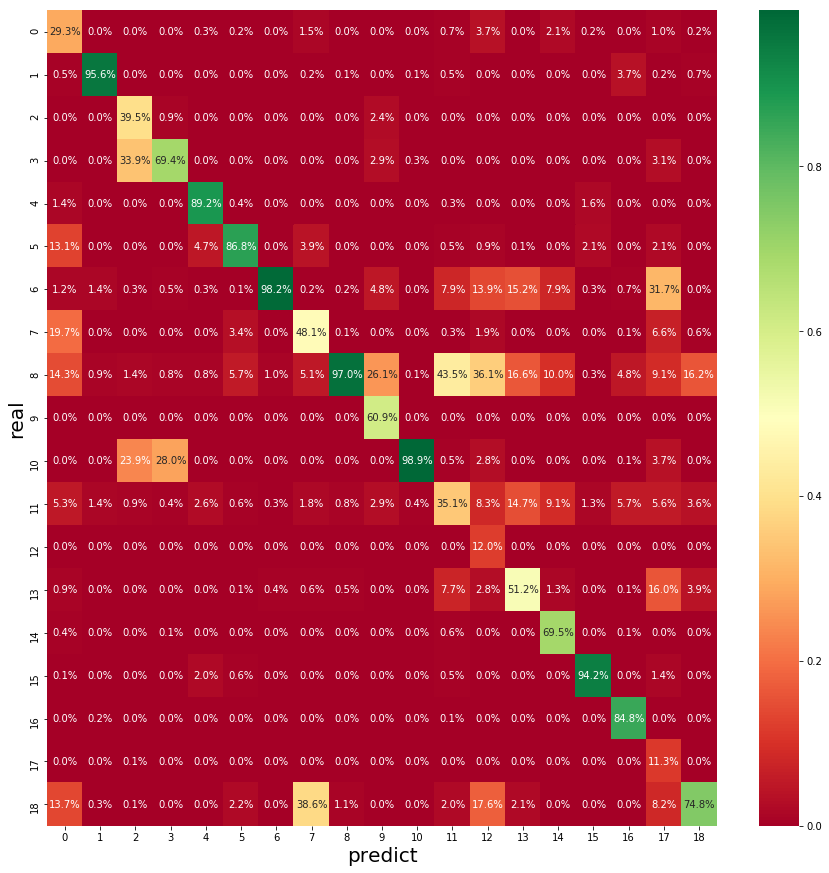

In [59]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

In [60]:
result = pd.Series(np.argmax(oof_pred,axis =1)).value_counts()
names = []
for i in result.index:
    names.append(number_columns[i])
result.index = names

In [61]:
result

QSO                    39800
GALAXY                 34985
SERENDIPITY_BLUE       23443
REDDEN_STD             15921
SPECTROPHOTO_STD       15065
STAR_BHB               13048
STAR_RED_DWARF         12694
SERENDIPITY_FIRST      10096
STAR_CATY_VAR           6466
STAR_WHITE_DWARF        6052
SERENDIPITY_DISTANT     5800
ROSAT_D                 5505
STAR_CARBON             4583
SERENDIPITY_RED         3023
STAR_SUB_DWARF          1340
STAR_BROWN_DWARF        1183
SERENDIPITY_MANUAL       486
SKY                      207
STAR_PN                  108
dtype: int64

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('submission.csv', index=True)

## Modeling